# Clustering


In [3]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# other packages
import pandas as pd
import numpy as np
import csv
import re

In [4]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

with open("Epidermal_growth_factor_receptor_erbB1_IC50.csv") as inp:
    EGFR = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in EGFR:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "EGFR"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])

In [5]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

In [6]:
# pick 1000 diverse structures from drugbank 
num_of_struct = 1000
drugbank = pd.DataFrame(drugbank, columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
picker = MaxMinPicker()
indices = picker.LazyBitVectorPick(drugbank['fps'], drugbank.shape[0], num_of_struct, seed=23)
drugbank = drugbank.loc[indices]


In [7]:
# pick 1000 diverse structures from EGFR ligands
EGFR = pd.DataFrame(EGFR, columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
indices = picker.LazyBitVectorPick(EGFR['fps'], EGFR.shape[0], num_of_struct, seed=23)
EGFR = EGFR.loc[indices]

In [8]:
#df = pd.DataFrame((*drugbank, *EGFR), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
df = pd.concat([drugbank, EGFR])
# adds index as normal column
df.reset_index(level=0, inplace=True)

In [9]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [10]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [11]:
sparse_mat = distance.pdist(list(df["fps"]), metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [12]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

In [13]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

/opt/bio-class/miniconda/envs/cdd/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


## Hierarchical clustering
[Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)

In [66]:
# Function for purity calculation

def purity(df):
    whole_len = df.shape[0]
    df = df[df.source=='drugbank']
    
    return max(df.shape[0]/whole_len, (1-df.shape[0]/whole_len))
    

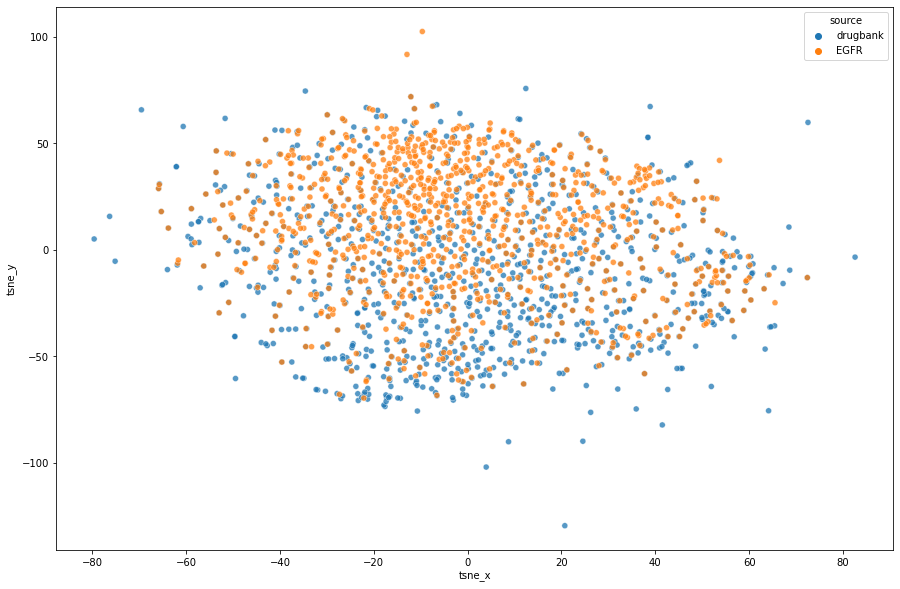

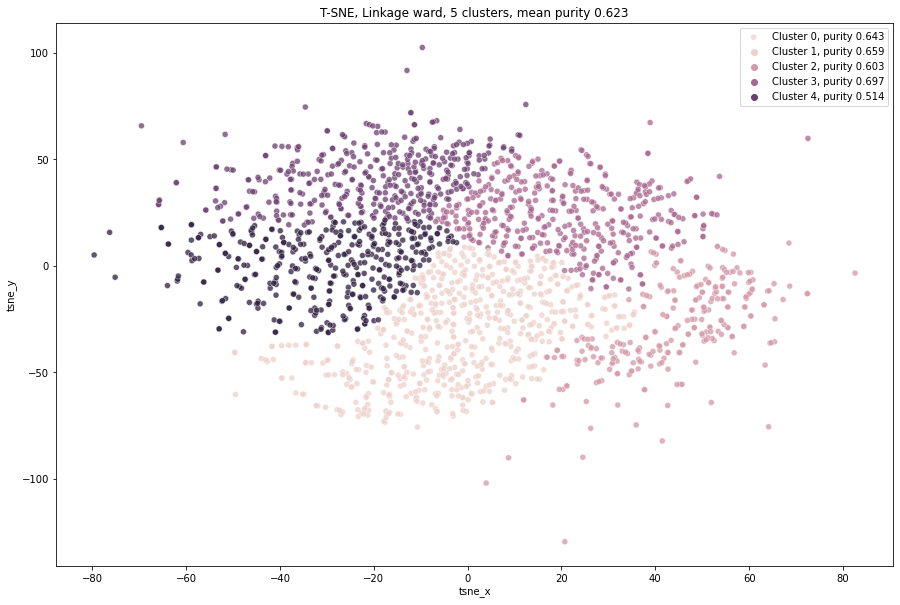

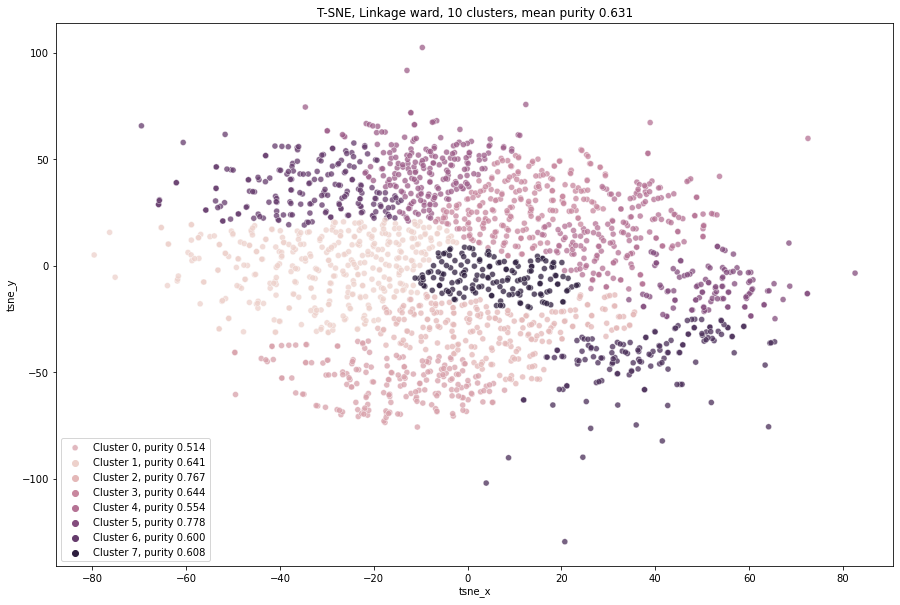

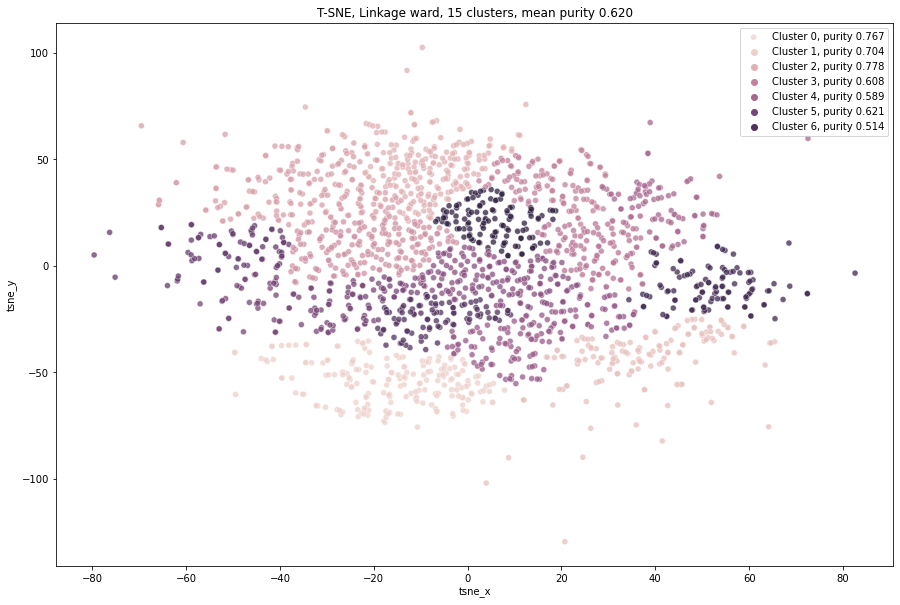

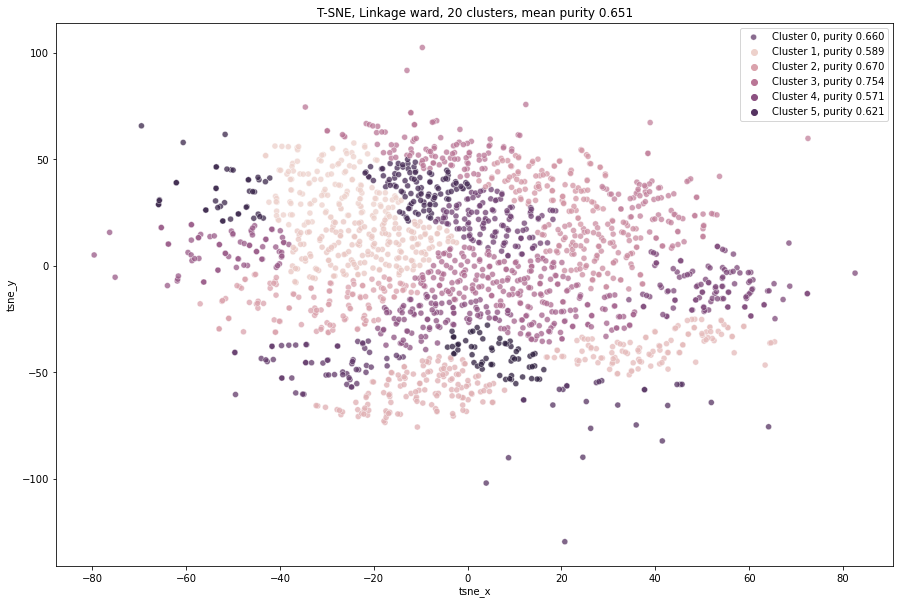

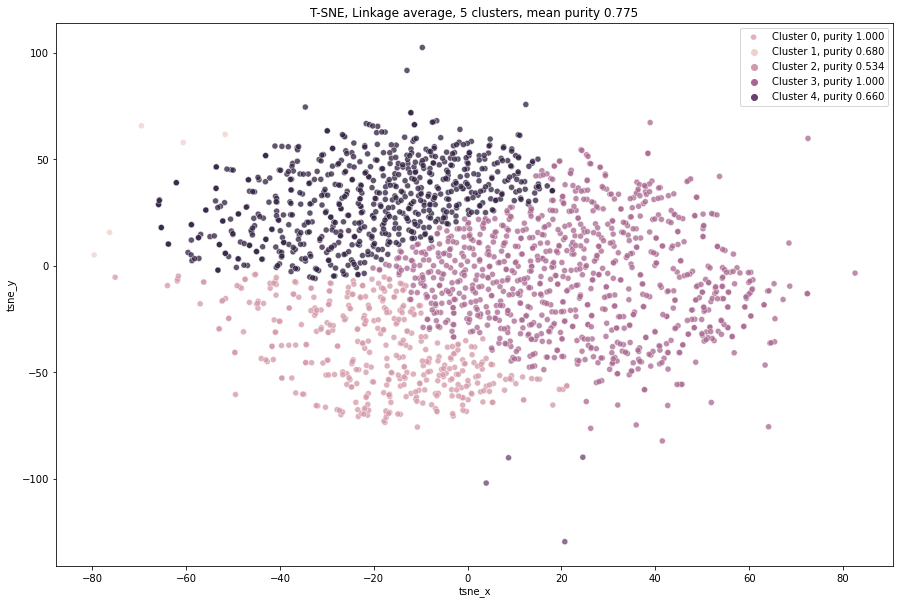

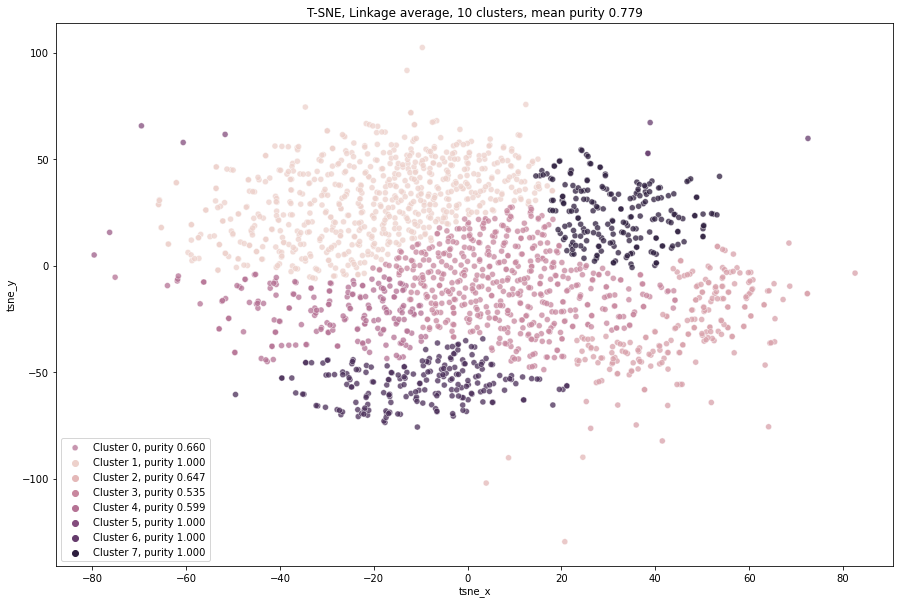

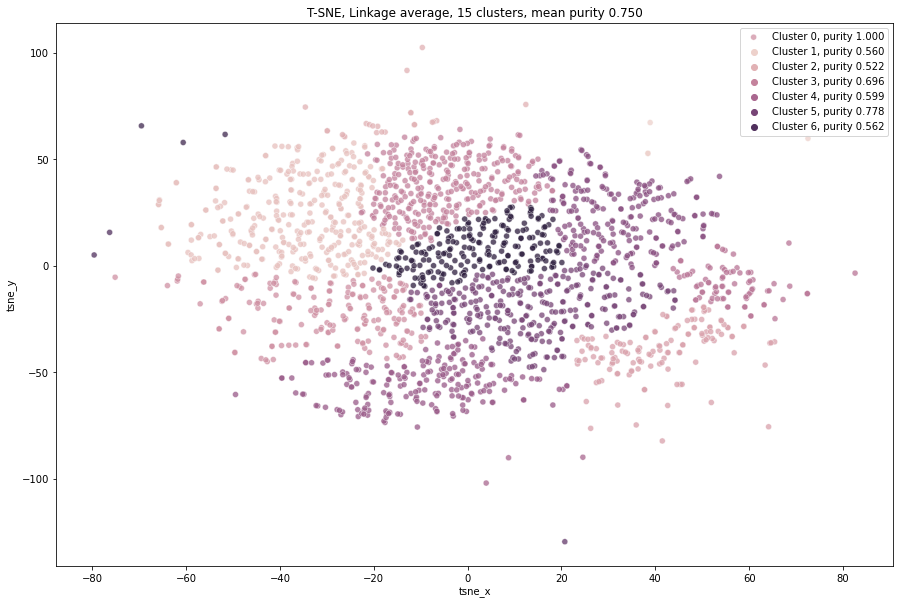

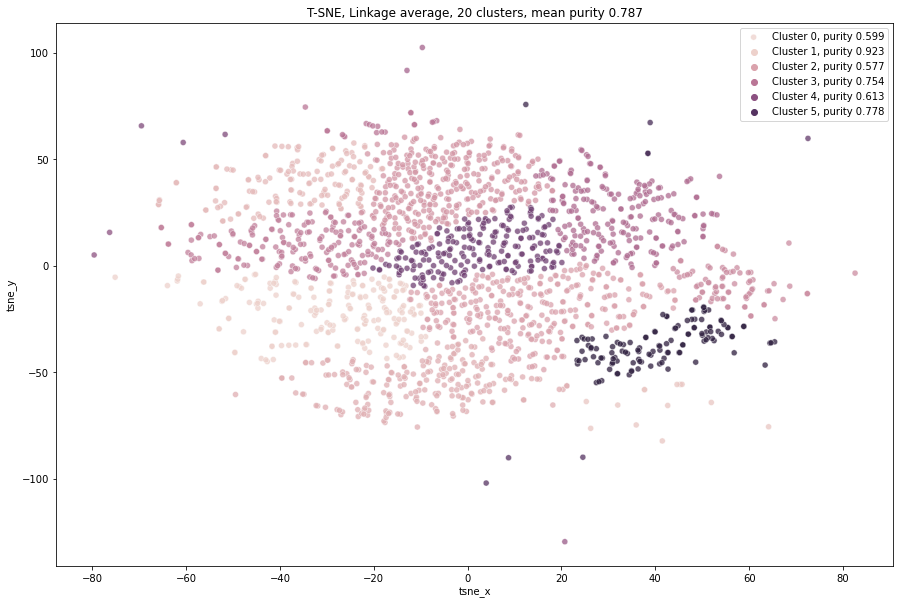

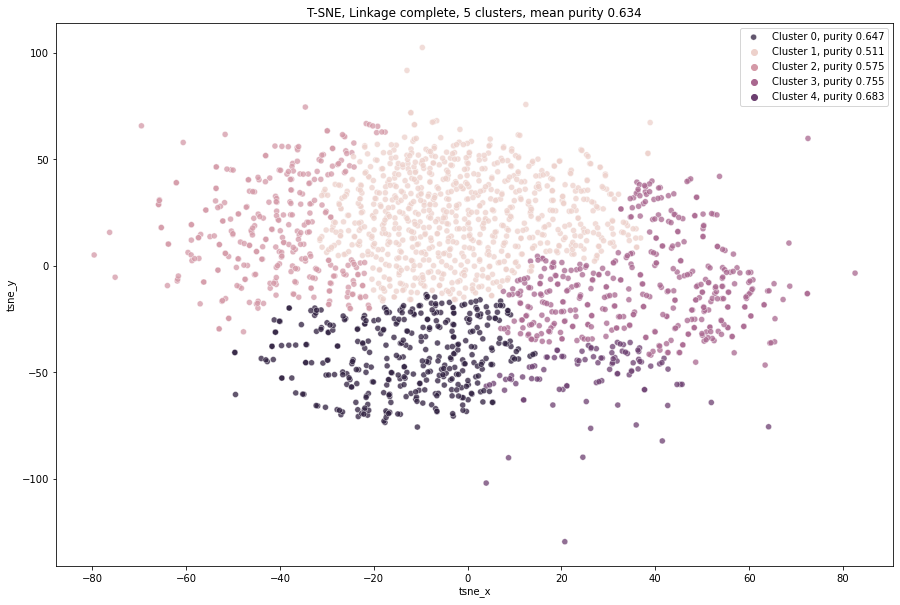

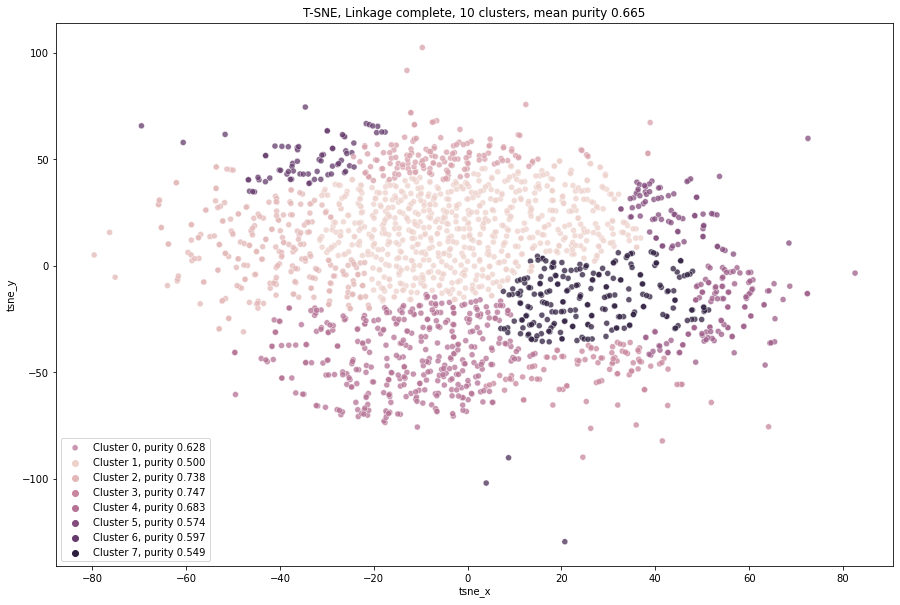

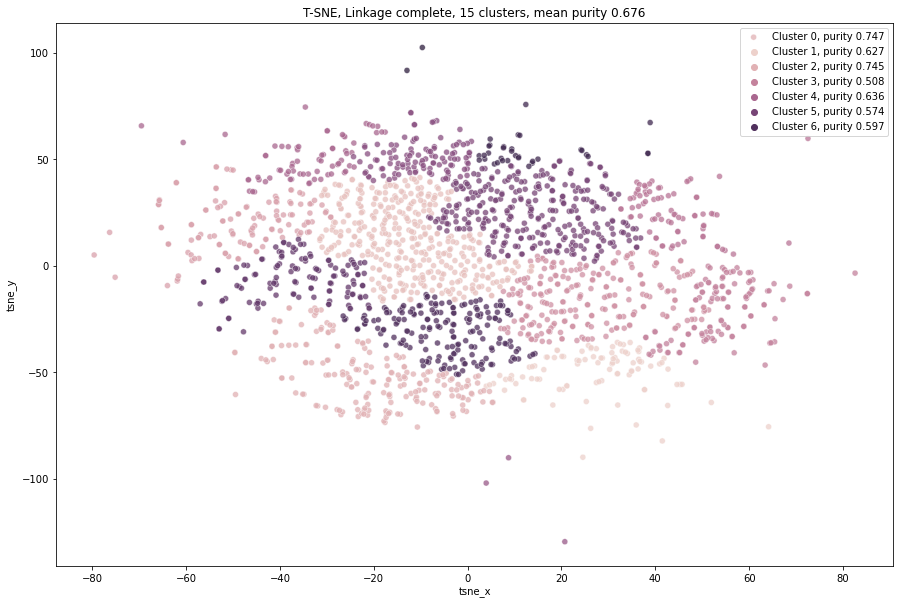

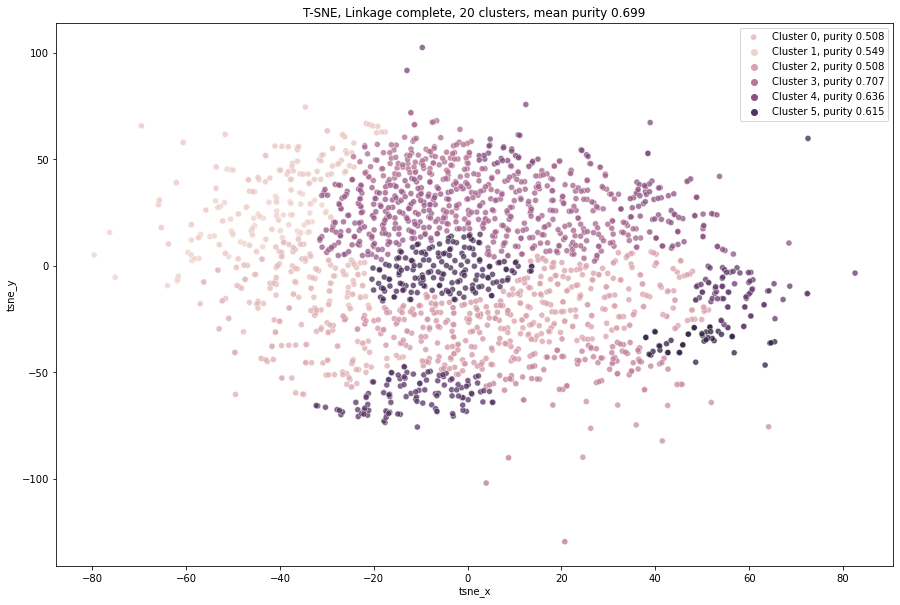

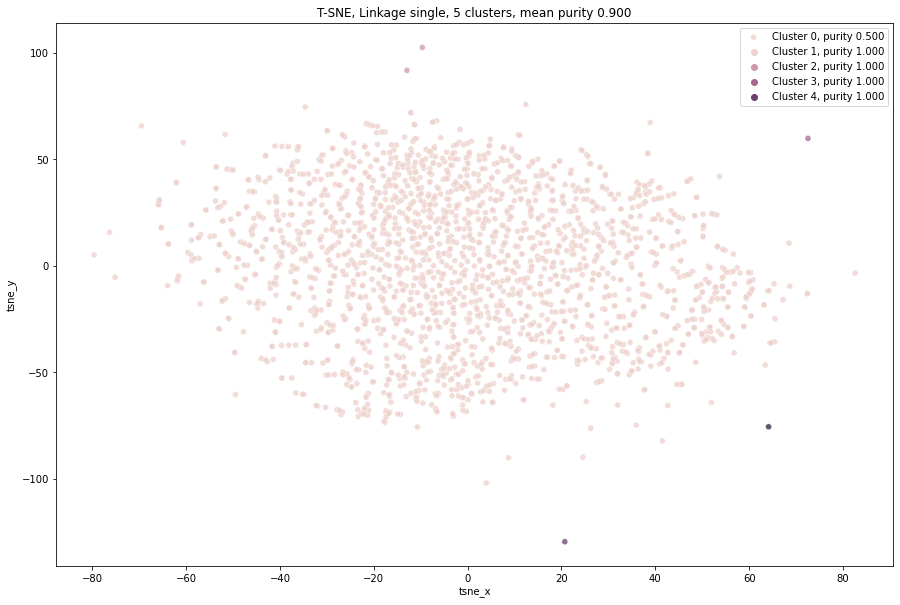

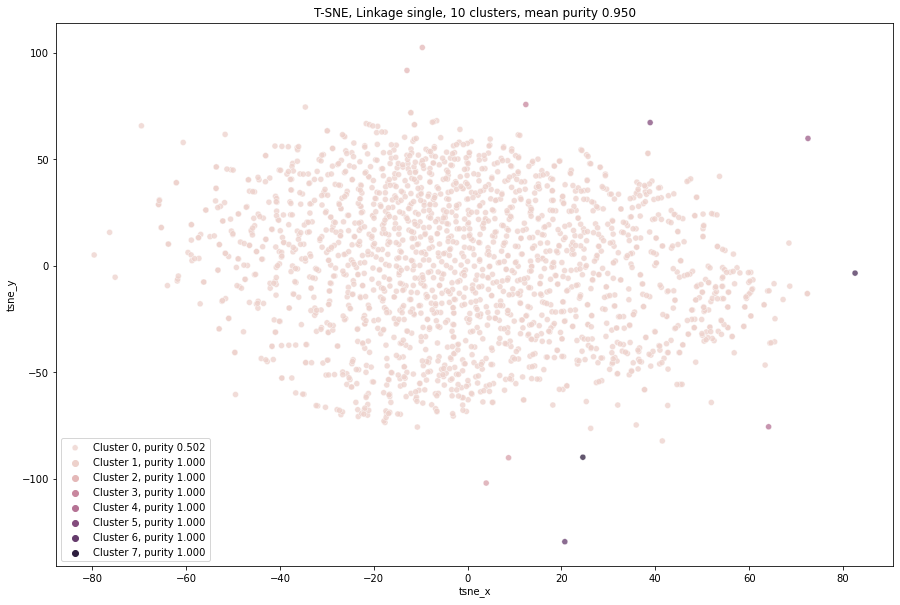

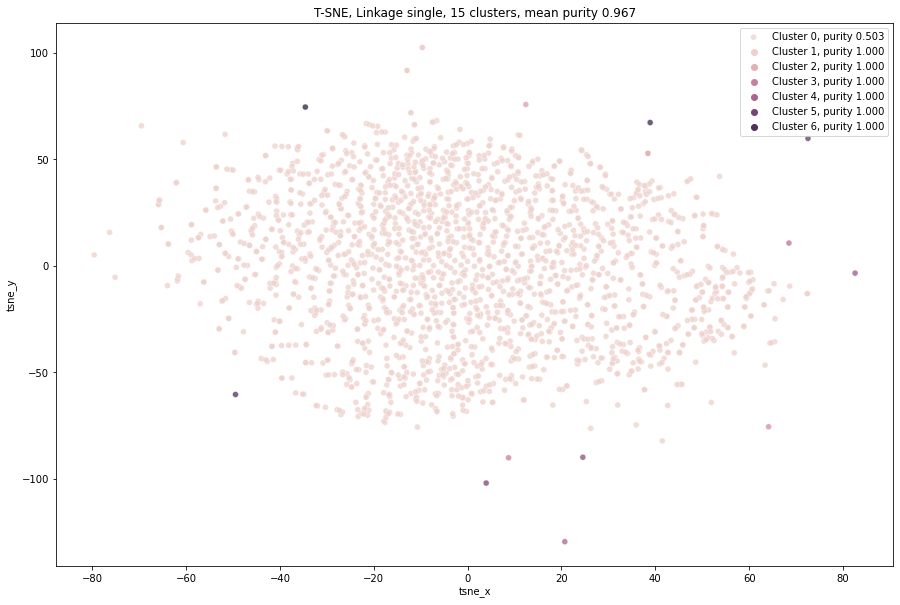

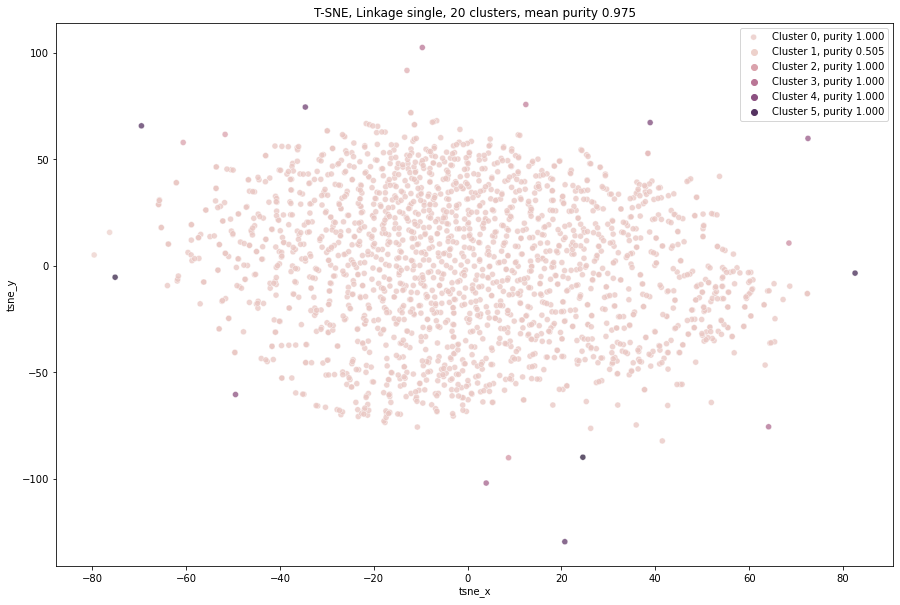

In [72]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

seaborn.set_palette(seaborn.color_palette('tab10'))

for linkage in ('ward', 'average', 'complete', 'single'):
    for n_cl in [5,10,15,20]:
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_cl)
        clustering.fit(df[["tsne_x", "tsne_y"]])
        uniq = list(np.unique(clustering.labels_))
        
        leg = []
        all_pur = 0
        for cl in uniq:
            pur = purity(df.loc[clustering.labels_ == cl])
            leg.append(f'Cluster {cl}, purity {pur:.3f}')
            all_pur += pur

        fig, ax = pyplot.subplots(figsize=(15,10))
        p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue=clustering.labels_,
                      ax=ax,
                      palette=seaborn.set_palette(seaborn.color_palette('dark')),
                      alpha=0.75
                     ).set_title(f"T-SNE, Linkage {linkage}, {n_cl} clusters, mean purity {all_pur/(len(uniq)):.3f}")
        pyplot.legend(labels=leg)
        

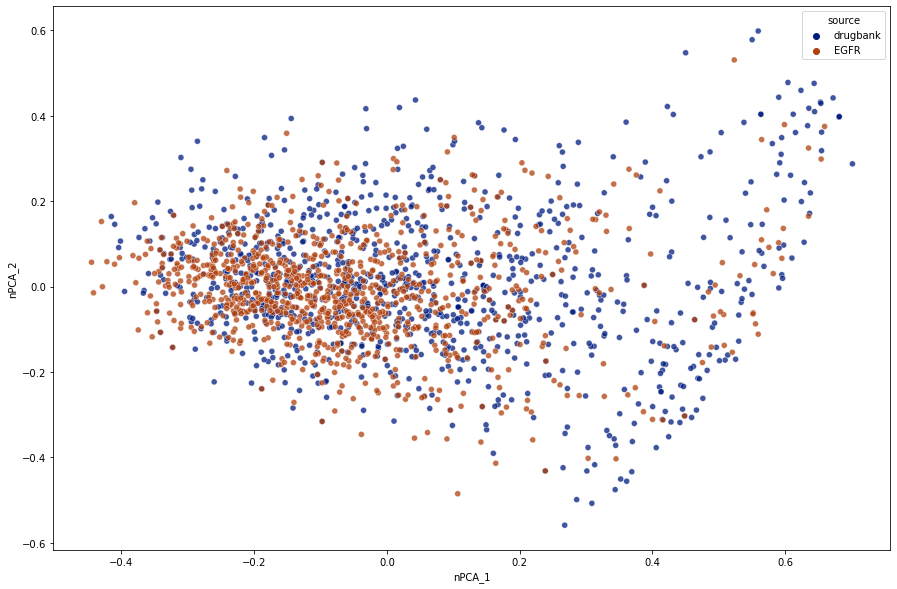

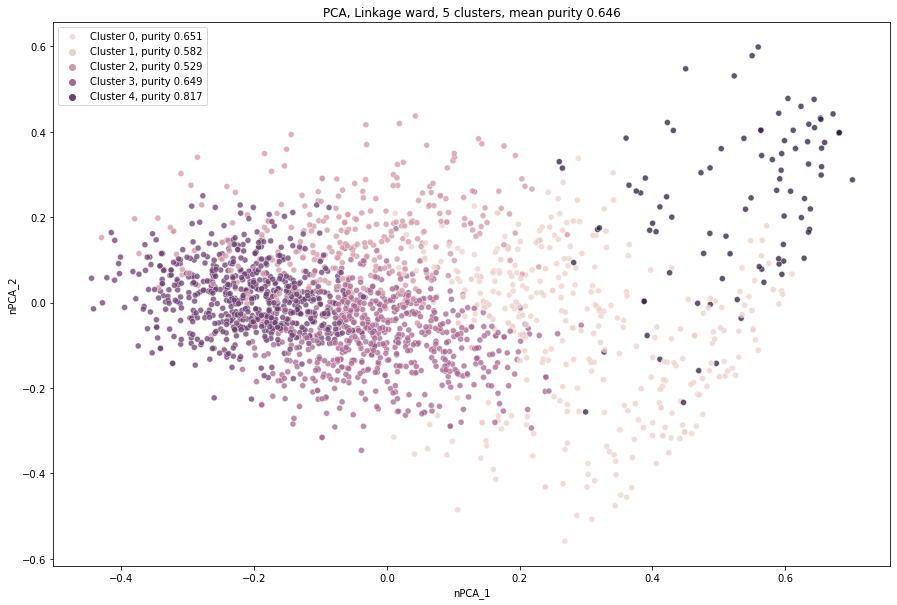

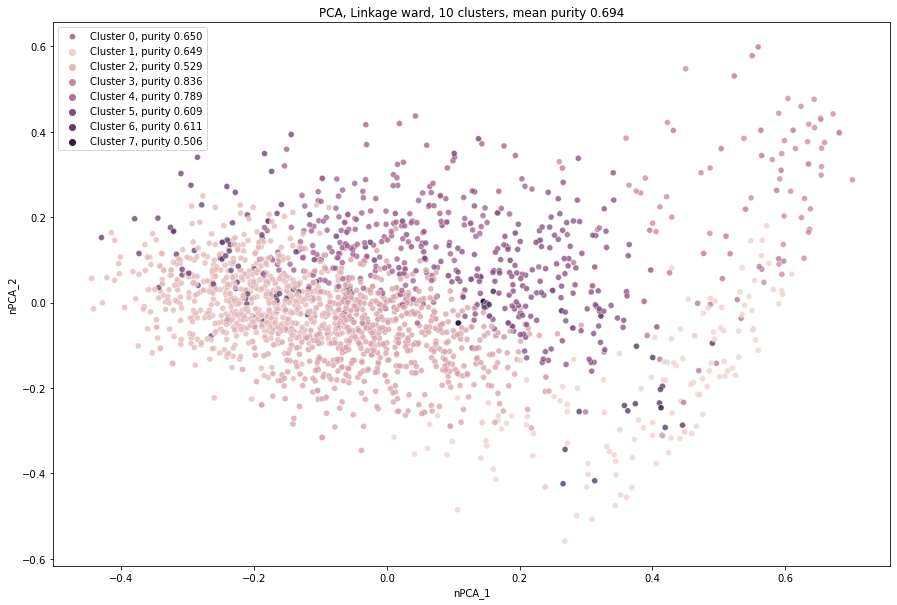

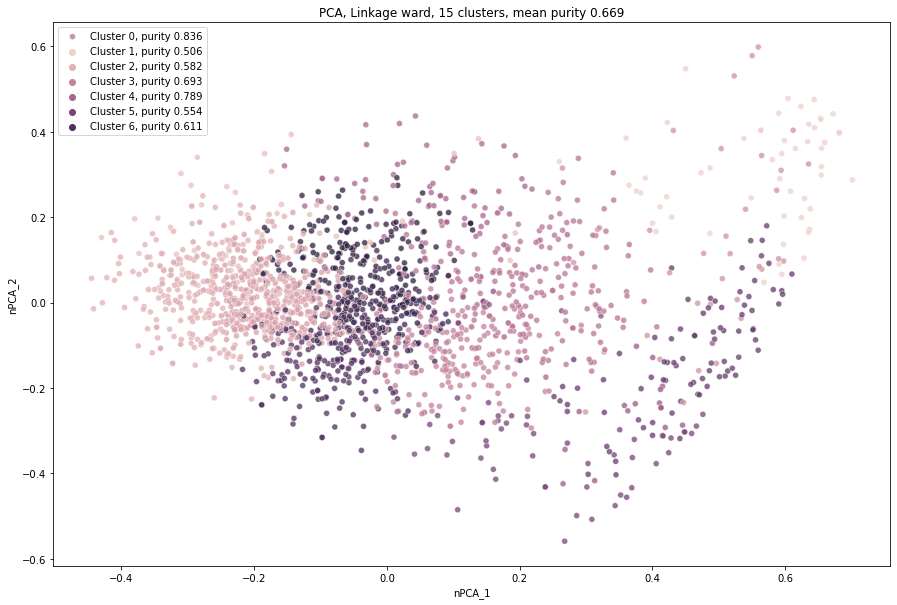

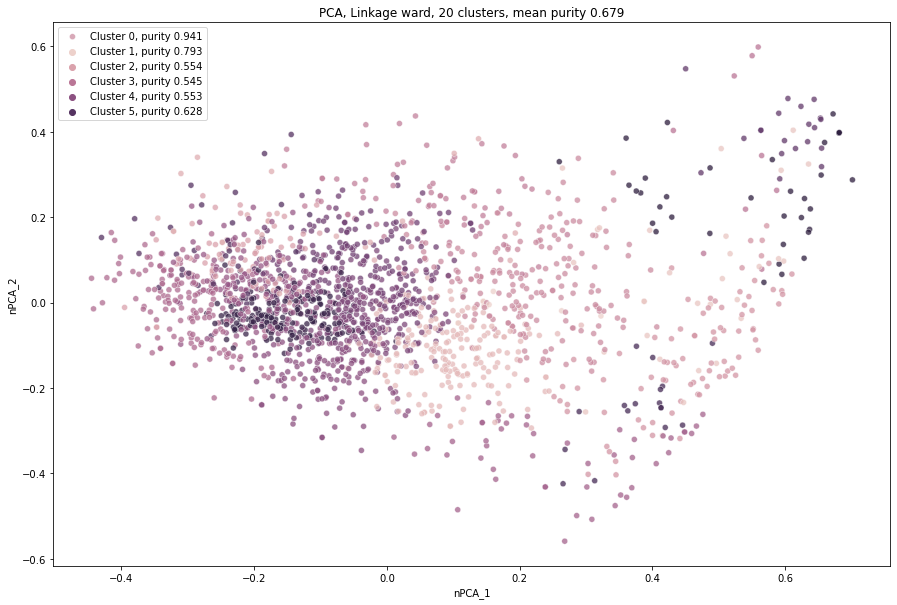

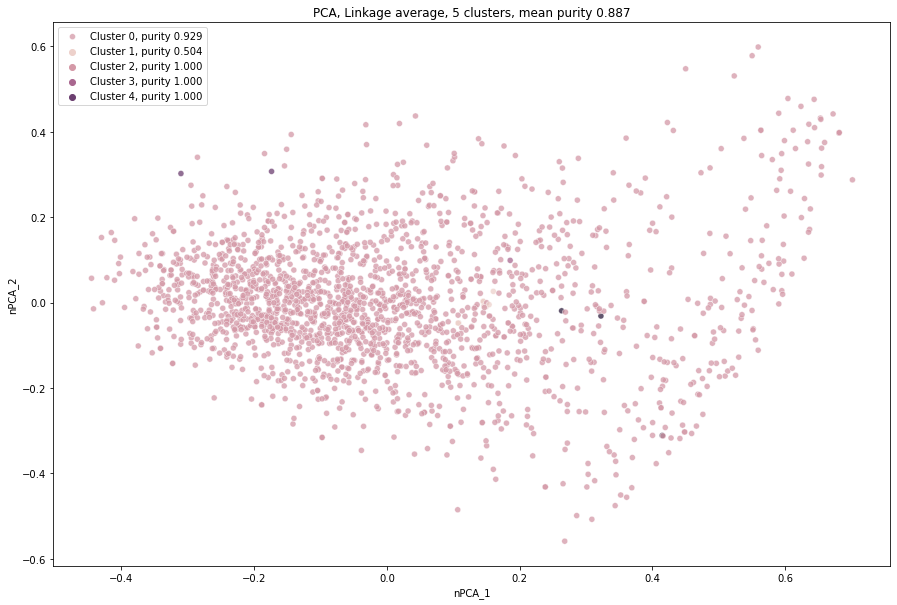

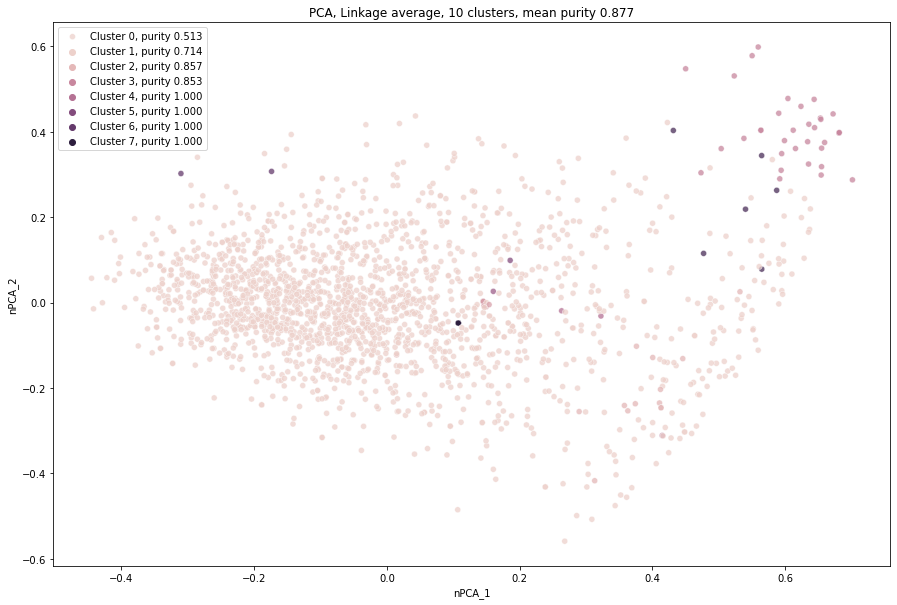

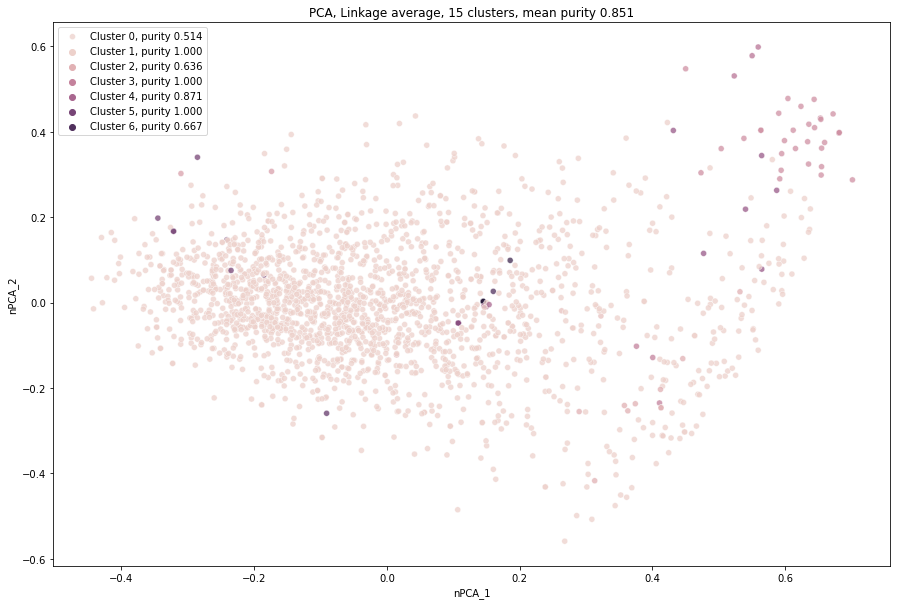

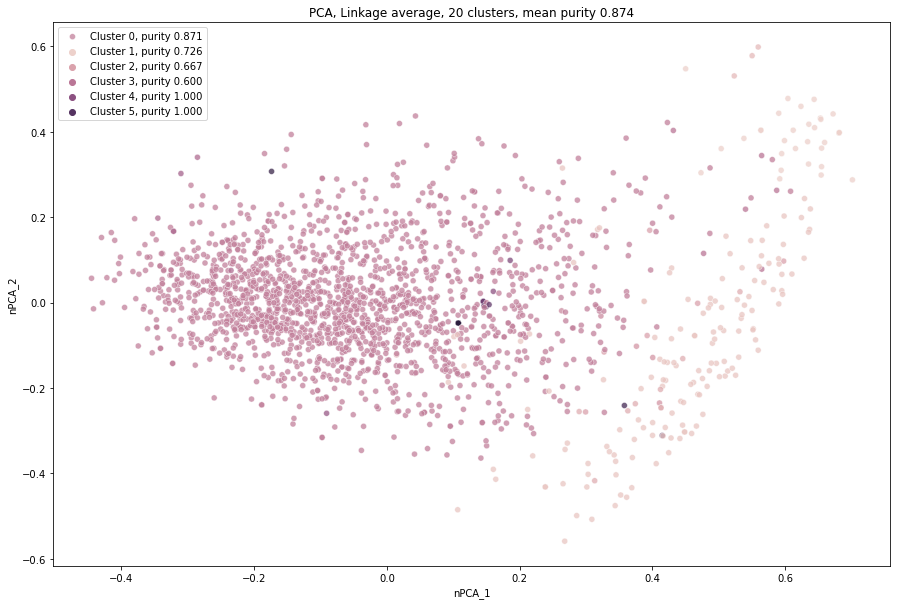

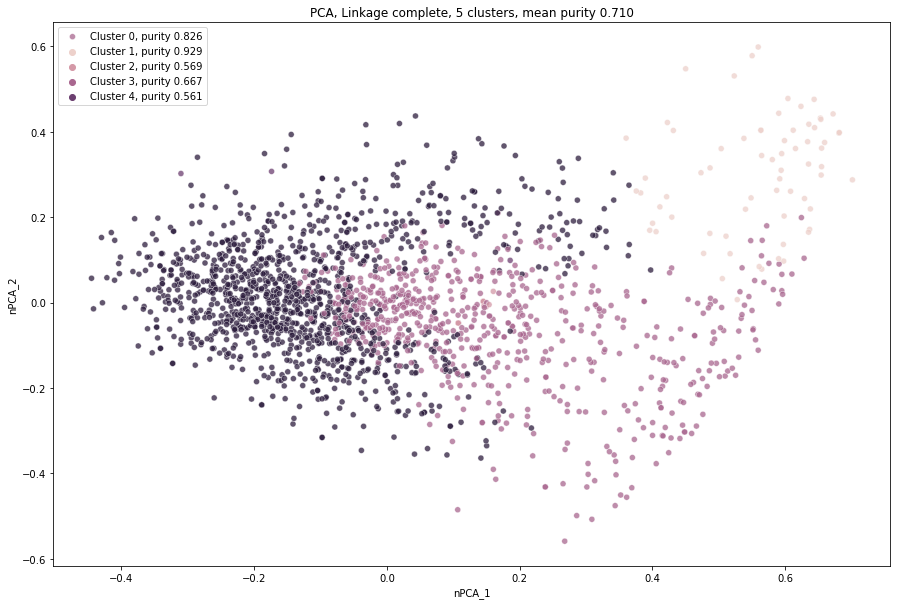

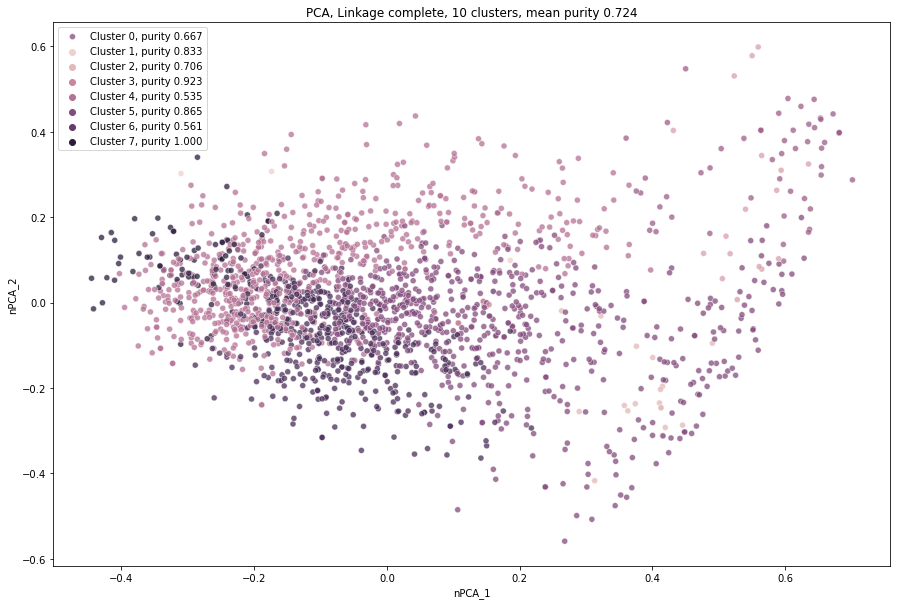

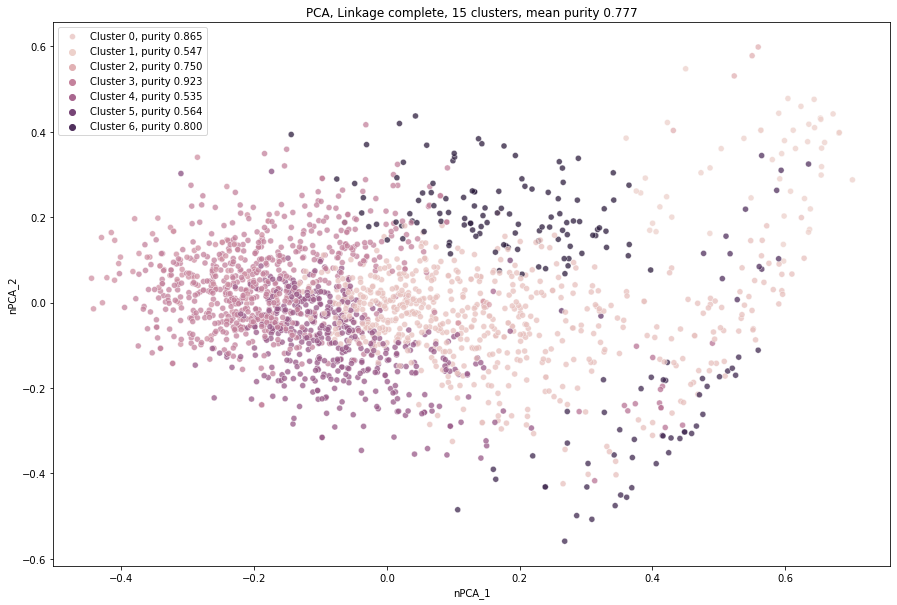

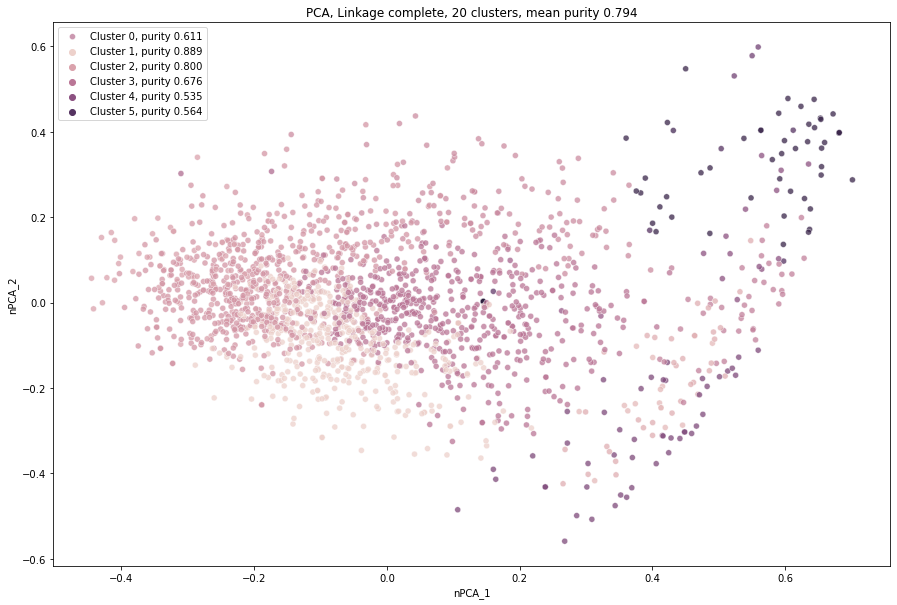

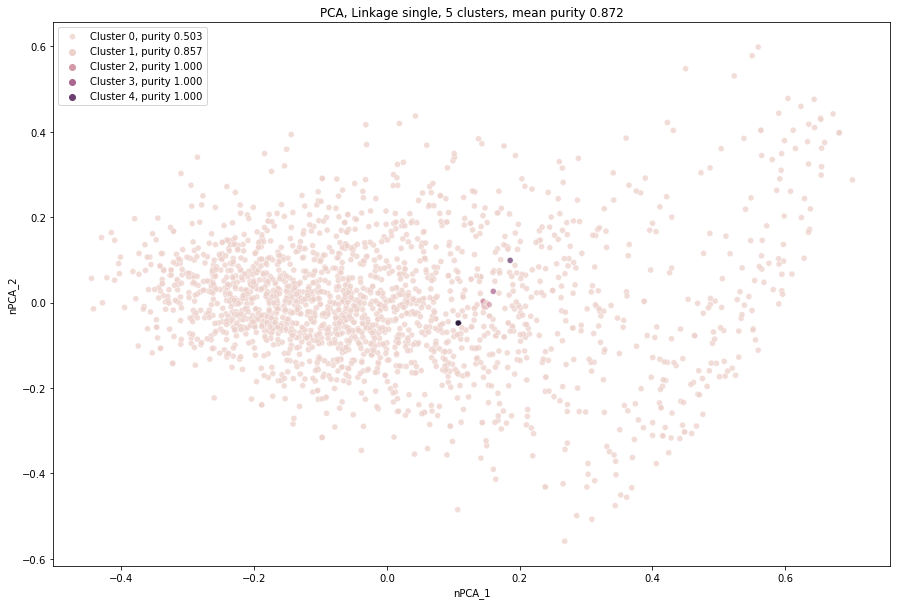

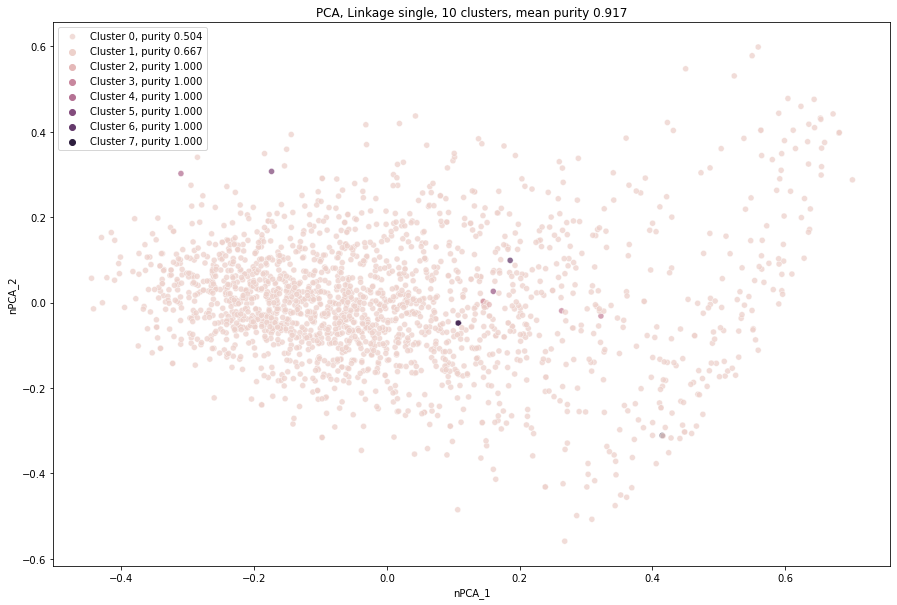

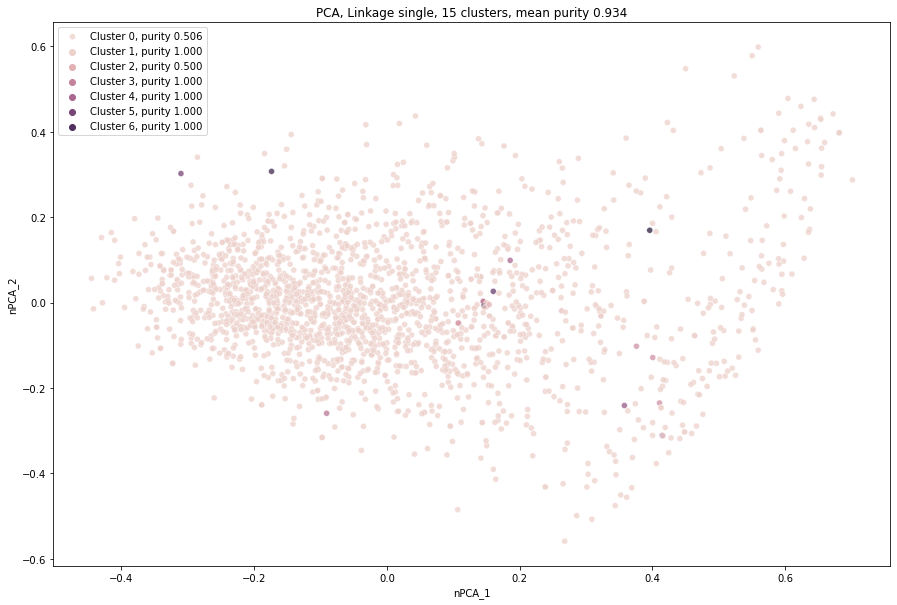

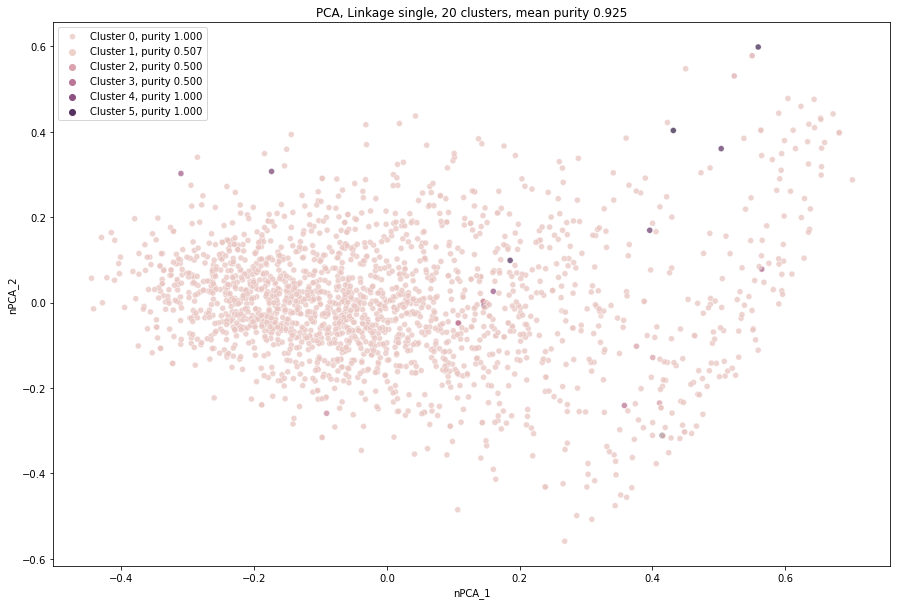

In [74]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

for linkage in ('ward', 'average', 'complete', 'single'):
    for n_cl in [5,10,15,20]:
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_cl)
        clustering.fit(df[[f"nPCA_{x}" for x in range(1, 43)]])
        uniq = list(np.unique(clustering.labels_))
        
        leg = []
        all_pur = 0
        for cl in uniq:
            pur = purity(df.loc[clustering.labels_ == cl])
            leg.append(f'Cluster {cl}, purity {pur:.3f}')
            all_pur += pur

        fig, ax = pyplot.subplots(figsize=(15,10))
        p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue=clustering.labels_,
                      ax=ax,
                      palette=seaborn.set_palette(seaborn.color_palette('dark')),
                      alpha=0.75
                     ).set_title(f"PCA, Linkage {linkage}, {n_cl} clusters, mean purity {all_pur/(len(uniq)):.3f}")
        pyplot.legend(labels=leg)
        

## K-means clustering algorithm 

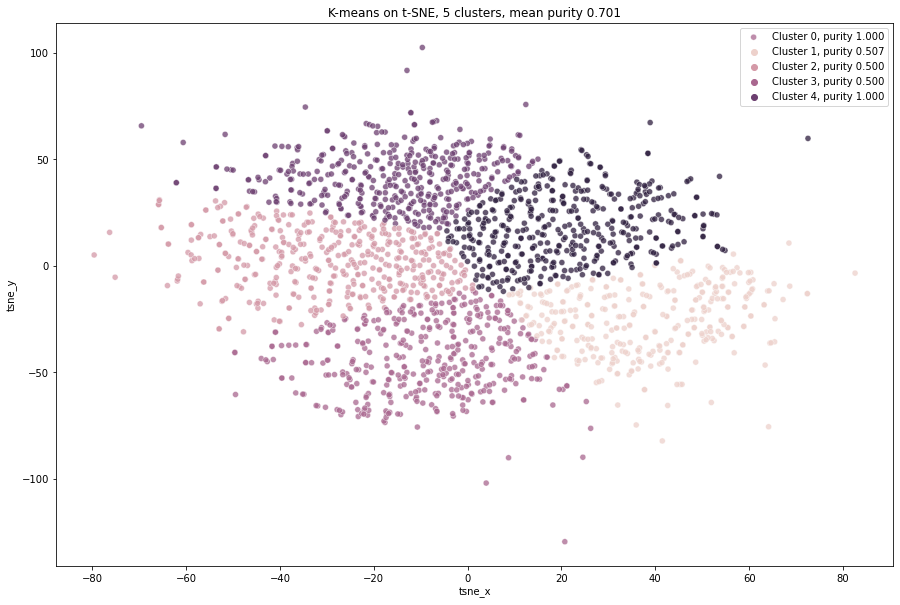

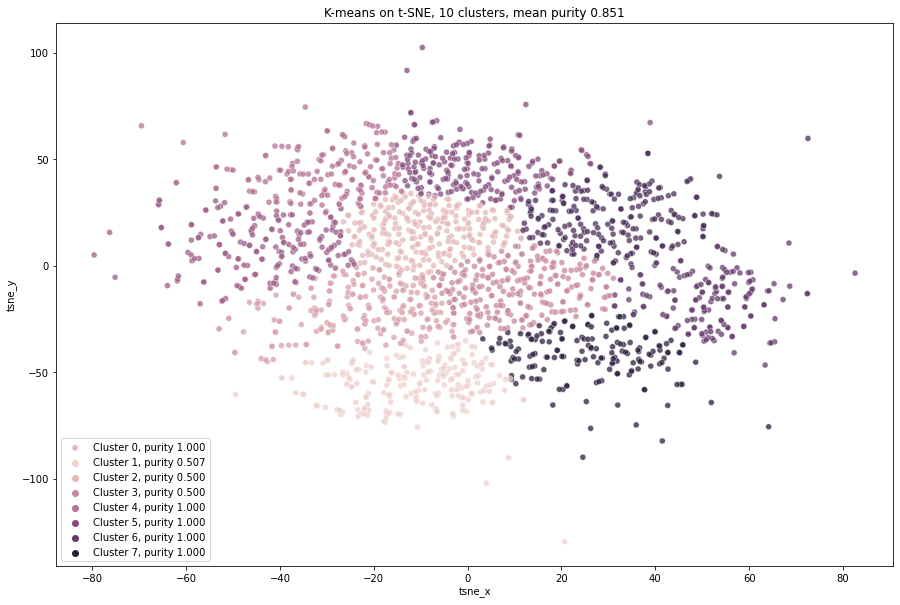

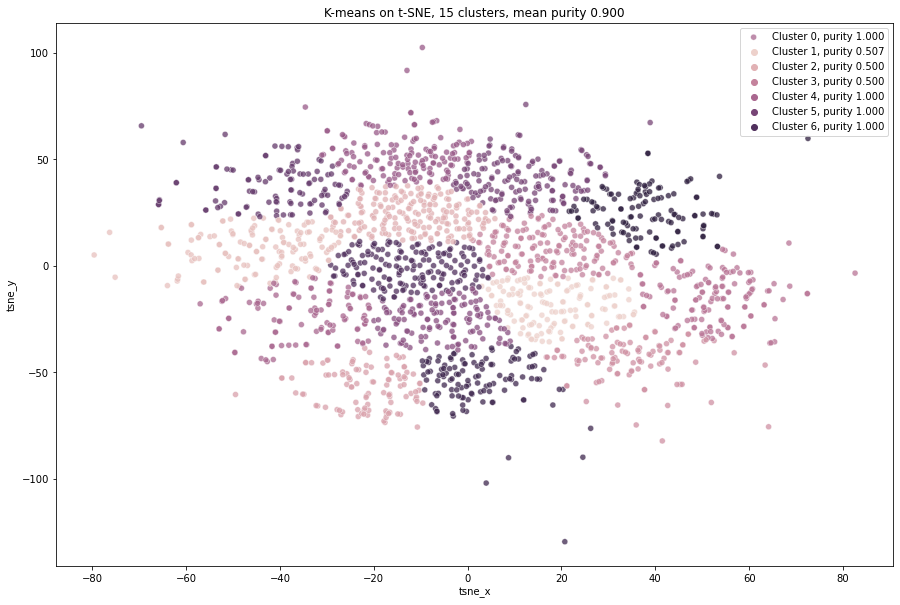

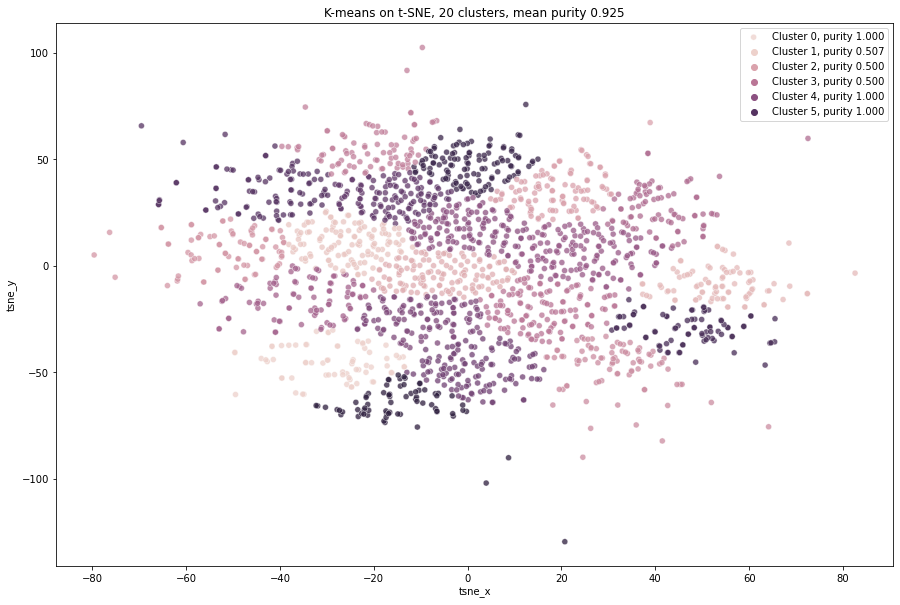

In [101]:
reduced_data = df[["tsne_x", "tsne_y"]]

for n_cl in [5, 10, 15, 20]:
    kmeans = KMeans(init="k-means++", n_clusters=n_cl)
    kmeans.fit(reduced_data)
    centroids = kmeans.cluster_centers_
    
    uniq = list(np.unique(kmeans.labels_))
    
    leg = []
    all_pur = 0
    for cl in uniq:
        pur = purity(df.loc[clustering.labels_ == cl])
        leg.append(f'Cluster {cl}, purity {pur:.3f}')
        all_pur += pur
            
    # Put the result into a color plot
    fig, ax = pyplot.subplots(figsize=(15,10))
    p=seaborn.scatterplot(x= "tsne_x",
                  y="tsne_y",
                    data=reduced_data,
                  hue=kmeans.labels_,
                  ax=ax,
                  alpha=0.75
                 ).set_title(f"K-means on t-SNE, {n_cl} clusters, mean purity {all_pur/(len(uniq)):.3f}")
    pyplot.legend(labels=leg)
        